In [1]:
!pip install -q shapely
!pip install -q --upgrade pandas
!pip install -q --upgrade fsspec
!pip install -q pandarallel
!pip install -q googlemaps
!pip install -q geopandas
!pip install -q descartes
!pip install -q awswrangler
!pip install -q arcgis
!pip install arcgis
!pip install --upgrade scikit-learn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrad

In [27]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

import geopandas as gpd
    
def plot_points(lat, lng, centers, labels, n_clusters):
    fig, ax = plt.subplots(figsize=(8,8))

    types = []
    all_points = []
    for ix in range(n_clusters):
        temp = [Point(x, y) for lab, x, y in zip(labels, lat, lng) if lab == ix]
        all_points += temp
        types += [ix] * len(temp)

    temp = [Point(x, y) for lab, x, y in zip(labels, lat, lng) if lab == -1]
    all_points += temp
    types += [n_clusters] * len(temp)

    for ix in range(n_clusters):
        temp = [Point(x, y) for x, y in [centers[ix]]]
        all_points += temp
        types += [n_clusters + 1 + ix] * len(temp)

    results = pd.DataFrame()
    results['geometry'] = all_points
    results['types'] = types
    
    df_geo = gpd.GeoDataFrame(results, geometry=all_points)
    
    if -1 in list(set(types)):
        df_geo.loc[df_geo.types == n_clusters].geometry.plot(ax=ax, color="red", markersize=100)
    
    for ix in list(set(types)):
        if ix != n_clusters:
            df_geo.loc[df_geo.types == ix].geometry.plot(ax=ax, color="black", markersize=100)
            df_geo.loc[df_geo.types == n_clusters + 1 + ix].geometry.plot(ax=ax, color="black", markersize=100, marker='*')
    
    plt.plot()

In [73]:
from sklearn.base import BaseEstimator, ClusterMixin
import random
import pandas as pd
import numpy as np
import copy
import types
from sklearn.utils.extmath import row_norms
from sklearn.cluster import kmeans_plusplus

def get_center_shift(centers, centers_old):
    shift = 0
    for center, center_old in zip(centers, centers_old):
        shift += np.linalg.norm(center - center_old)

    return shift
        
def get_distances(point:list, centers:list):
    distances = []
    for center in centers:
        distances.append(np.linalg.norm(center - point))
    return distances

def run_kmeans(X:list, attention_start:list, attention_finish:list, centers:list, distance_function:types.LambdaType, cluster_iter:int, n_clusters:int, tol:float, optimize_iterations:bool, time_diff:float=5, verbose:bool=True):
    
    centers_old = np.zeros(centers.shape)

    labels = np.zeros(len(X), dtype=int)
    labels_old = np.zeros(len(X))
    distance_to_center = np.zeros(len(X))
    
    attended_flag = np.zeros(len(X), dtype=int)
    attended_by = [-1] * len(X)
    attended_by_old = [-1] * len(X)
    
    cant = 0
    for iter_n in range(cluster_iter):
        finish_time = np.zeros(n_clusters, dtype='<M8[ns]')

        for i in range(len(X)):
            if optimize_iterations:
                avaiability = np.array([j for j in range(n_clusters) if ((attention_start[i] - finish_time[j]) / np.timedelta64(1, 's')) >= 0])
                cluster = -1
                flag_distance = False
                
                if len(avaiability):
                    cant += 1
                    if attended_by[i] == -1 or attended_by[i] not in avaiability:
                        distances = distance_function(X[i], centers[avaiability])
                        flag_distance = True
                    else: 
                        avaiability_aux = avaiability[avaiability != attended_by[i]]
                        first_distance = distance_function(X[i], [centers[attended_by[i]]])
                        if (first_distance[0]  + time_diff) > distance_to_center[i]:
                            #Reduction request
                            distances = distance_function(X[i], centers[avaiability_aux]) + first_distance
                            avaiability = np.append(avaiability_aux, attended_by[i])
                            flag_distance = True
                    
                    #flag_distance = True
                    #distances = distance_function(X[i], centers[avaiability])
                    
                    if flag_distance:
                        sorted_distances = np.argsort(distances)

                        for distance_id in sorted_distances:
                            if (finish_time[avaiability[distance_id]] and ((attention_start[i] - finish_time[avaiability[distance_id]]) / np.timedelta64(1, 's')) >= 0) or not finish_time[avaiability[distance_id]]:
                                cluster = distance_id
                                break
                
                if flag_distance:
                    distance_to_center[i] = distances[cluster]
                    attended_flag[i] = 1
                    attended_by[i] = avaiability[cluster]
                    finish_time[cluster] = attention_finish[i]
                elif not flag_distance and len(avaiability):
                    finish_time[cluster] = attention_finish[i]
                else:
                    distance_to_center[i] = distances[cluster]
                    attended_flag[i] = 1
                    attended_by[i] = cluster
                    
            else:
                raise Exception('Not implemented')
                #distances = distance_function(X[i], centers)
                #cluster = np.argmin(distances)
                #labels[i] = cluster

        for i in range(n_clusters):
            points = [X[j] for j in range(len(X)) if attended_by[j] == i]
            if len(points):
                centers[i] = np.mean(points, axis=0)

        if np.array_equal(attended_by_old, attended_by):
            if verbose:
                print(f"Converged at iteration {iter_n}: strict convergence.")
            strict_convergence = True
            break
        else:
            center_shift_tot = get_center_shift(centers, centers_old)
            if center_shift_tot <= tol:
                if verbose:
                    print(f"Converged at iteration {iter_n}: center shift "
                          f"{center_shift_tot} within tolerance {tol}.")
                break
                
        centers_old = copy.deepcopy(centers)
        attended_by_old = copy.deepcopy(attended_by)
    
    return attended_by, centers

class FacilityEstimator(BaseEstimator, ClusterMixin):
    
    def __init__(self, n_clusters: int, init:str='kmeans++', tol:float=1e-4 , cluster_iter:int=50, verbose:bool=True, distance_function:types.LambdaType=get_distances, optimize_iterations:bool=True, random_state:int=0):
        self.n_clusters = n_clusters
        self.tol = tol
        self.init = init
        self.cluster_iter = cluster_iter
        self.verbose = verbose
        self.distance_function = distance_function
        self.random_state = random_state
        self.optimize_iterations = optimize_iterations
             
    def _init_centroids(self, X:list, x_squared_norms:list):
        
        if isinstance(self.init, str) and self.init == 'random':
            centers = np.random.permutation(X)[:self.n_clusters]
        elif isinstance(self.init, str) and self.init == 'kmeans++':
            centers, _ = kmeans_plusplus(X, self.n_clusters,
                                          random_state=self.random_state,
                                          x_squared_norms=x_squared_norms)
        else:
            raise Exception('Not implemented')
            
        return centers
            
    def fit(self, X, attention_hour, attention_times, y=None, sample_weight=None):
        
        x_squared_norms = row_norms(X, squared=True)
        
        centers = self._init_centroids(X, x_squared_norms)
        labels, centers = run_kmeans(X, attention_hour, attention_times, centers, self.distance_function, self.cluster_iter, self.n_clusters, self.tol, self.optimize_iterations, self.verbose)
        
        self.labels = labels
        self.cluster_centers_ = centers

        return self
    
    def predict(self, X, sample_weight=None):
        pass
        

In [3]:
data = pd.read_csv('../../../Outputs/atenciones_filtradas.csv')

In [4]:
data['fecha_hora_de_asignacion_al_proveedor'] = pd.to_datetime(data['fecha_hora_de_asignacion_al_proveedor'])
data['fecha_hora_culminacion_proveedor'] = pd.to_datetime(data['fecha_hora_culminacion_proveedor'])
data['tiempo_atencion'] = (data['fecha_hora_culminacion_proveedor'] - data['fecha_hora_de_asignacion_al_proveedor']).dt.seconds / 60

data['cast_fecha_hora'] = pd.to_datetime(data['fecha_hora_de_apertura'])


In [5]:
import arcgis
import pandas as pd
from arcgis.gis import GIS

df_routes = []

portal = GIS("https://www.arcgis.com", "dante_rivas_LearnArcGIS", "POSEIDON24")
route = arcgis.network.RouteLayer(portal.properties.helperServices.route.url,
                                          gis=portal)

In [6]:
from collections import Counter
def get_time_function(route):
    def get_time_distance(point:list, centers:list):
        distances = []
        for center in centers:
            stops = f"{point[1]},{point[0]};{center[1]},{center[0]}"

            result = route.solve(stops=stops,
                                    start_time="now",
                                    return_directions=False,
                                    directions_language="es",)

            time = result['routes']['features'][0]['attributes']['Total_TravelTime']
            distances.append(time)
            
        return distances
    
    return get_time_distance

In [9]:
data.sort_values(by='cast_fecha_hora', inplace=True)

In [56]:
data = data.loc[(data.fecha_hora_culminacion_proveedor.notnull()) &
               (data.cast_fecha_hora.notnull())]

In [57]:
cut = data.drop_duplicates('numero_del_caso').head(50).reset_index(drop=True)

In [58]:
data.fecha_hora_culminacion_proveedor.isnull().sum()

0

In [59]:
cut[cut.lng  == -77.1094735][['lat', 'lng',
                             'cast_fecha_hora',
                             'fecha_hora_culminacion_proveedor']]

,lat,lng,cast_fecha_hora,fecha_hora_culminacion_proveedor
22,-12.072682,-77.109473,2020-11-08 02:11:00,2020-11-08 03:30:00


In [63]:
cut[cut.lng  > -76.80][['lat', 'lng',
                             'cast_fecha_hora',
                             'fecha_hora_culminacion_proveedor']]

,lat,lng,cast_fecha_hora,fecha_hora_culminacion_proveedor
30,-11.97476,-76.760437,2020-11-09 22:27:00,2020-11-09 23:38:00


Point 0  Iter 0 Value: [-12.0623232 -77.078413 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000']
Start time: 2020-11-01T10:59:00.000000000
avaiability [0 1 2 3 4]
sorted_distances [3 2 0 1 4]
ASSIGNED CLUSTER 3
Point 1  Iter 0 Value: [-12.1184434 -77.004967 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '2020-11-01T11:39:00.000000000'
 '1970-01-01T00:00:00.000000000']
Start time: 2020-11-02T00:08:00.000000000
avaiability [0 1 2 3 4]
sorted_distances [0 3 2 1 4]
ASSIGNED CLUSTER 0
Point 2  Iter 0 Value: [-12.0841629 -77.0400128]
finish_time: ['2020-11-02T00:59:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '2020-11-01T11:39:00.000000000'
 '1970-01-01T00:00:00.000000000']
Start time: 2020-11-02T05:23:00.000000000
avaiability [0 1 2 3 4]
sorted_distances [3 0 2 1 4]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Centers BEFORE: [[-12.1145578 -76.9844516]
 [-11.8782732 -77.126587 ]
 [-11.9883358 -77.0648033]
 [-12.0727302 -77.0924767]
 [-11.9747601 -76.7604373]]
Centers  AFTER: [[-12.11680003 -76.98499615]
 [-11.8782732  -77.126587  ]
 [-12.00205419 -77.06014209]
 [-12.09325671 -77.04884375]
 [-11.9747601  -76.7604373 ]]
Attended counter Counter({0: 24, 3: 14, 2: 10, 4: 1, 1: 1})
50


Point 0  Iter 1 Value: [-12.0623232 -77.078413 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000']
Start time: 2020-11-01T10:59:00.000000000
avaiability [0 1 2 4 3]
sorted_distances [4 2 0 1 3]
ASSIGNED CLUSTER 3
Point 1  Iter 1 Value: [-12.1184434 -77.004967 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '2020-11-01T11:39:00.000000000']
Start time: 2020-11-02T00:08:00.000000000
avaiability [

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Centers BEFORE: [[-12.11680003 -76.98499615]
 [-11.8782732  -77.126587  ]
 [-12.00205419 -77.06014209]
 [-12.09325671 -77.04884375]
 [-11.9747601  -76.7604373 ]]
Centers  AFTER: [[-12.1185691  -76.98358034]
 [-11.8782732  -77.126587  ]
 [-12.00205419 -77.06014209]
 [-12.09022403 -77.05127084]
 [-11.9747601  -76.7604373 ]]
Attended counter Counter({0: 24, 3: 14, 2: 10, 4: 1, 1: 1})
100


Point 0  Iter 2 Value: [-12.0623232 -77.078413 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000']
Start time: 2020-11-01T10:59:00.000000000
avaiability [0 1 2 4 3]
sorted_distances [4 2 0 1 3]
ASSIGNED CLUSTER 3
Point 1  Iter 2 Value: [-12.1184434 -77.004967 ]
finish_time: ['1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '1970-01-01T00:00:00.000000000' '1970-01-01T00:00:00.000000000'
 '2020-11-01T11:39:00.000000000']
Start time: 2020-11-02T00:08:00.000000000
av

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


FacilityEstimator(cluster_iter=3,
                  distance_function=<function get_time_function.<locals>.get_time_distance at 0x7fe938416598>,
                  n_clusters=5)

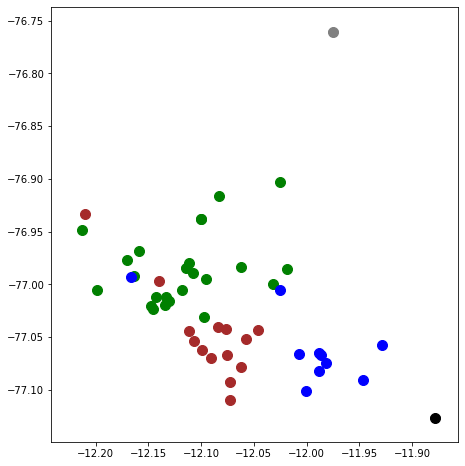

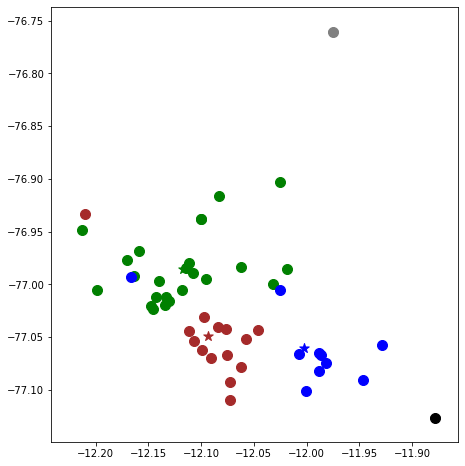

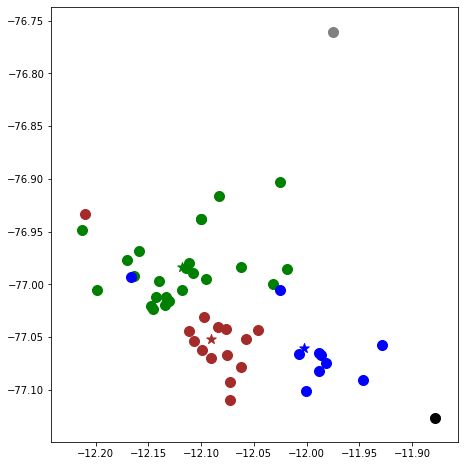

In [74]:
%%time
from collections import Counter
kmeans = FacilityEstimator(5, cluster_iter=3, distance_function=get_time_function(route), optimize_iterations=True)
kmeans.fit(cut[['lat', 'lng']].values, 
           cut.cast_fecha_hora.values,
           cut.fecha_hora_culminacion_proveedor.values)


In [64]:
%%time
from collections import Counter
kmeans_with_reduction = Custom_Kmeans(5, distance_function=get_time_function(route))
kmeans_with_reduction.fit(data[['lat', 'lng']].head(50).values)

47
65
Converged at iteration 2: strict convergence.
CPU times: user 1.19 s, sys: 15.6 ms, total: 1.2 s
Wall time: 1min 21s


Custom_Kmeans(distance_function=<function get_time_function.<locals>.get_time_distance at 0x7fd7a4cdd488>,
              n_clusters=5)

In [67]:
100 * 5, 65 * 5 + 100 - 65

(500, 360)

In [48]:
np.delete(kmeans.cluster_centers_, 0, axis=0)

array([[-12.1122337, -76.9820314],
       [-11.9476871, -76.7216086],
       [-12.1075724, -77.0244171],
       [-12.0772019, -76.9064019]])

In [30]:
from sklearn.cluster import KMeans

normal_kmeans = KMeans(5, random_state=0)
normal_kmeans.fit(data[['lat', 'lng']].values)

KMeans(n_clusters=5, random_state=0)

In [165]:
(kmeans.labels)

[3, 1, 2, 2, 2, 1, 3, 3, 3, 2, 4, 3, 3, 0, 0, 3, 1, 2, 0, 3]

In [166]:
cut = cut.reset_index()
cut[(cut.lng > -76.95)][['lng', 'lat']]

,lng,lat
10,-76.933697,-12.210008
16,-76.937583,-12.099714


In [171]:
cut.drop_duplicates('numero_del_caso').shape, cut.shape

((14, 119), (20, 119))

In [167]:
kmeans.cluster_centers_

array([[-11.98098017, -77.07965617],
       [-12.1052842 , -76.99105793],
       [-12.10155424, -77.01633612],
       [-12.02990009, -77.06925495],
       [-12.2100081 , -76.9336971 ]])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


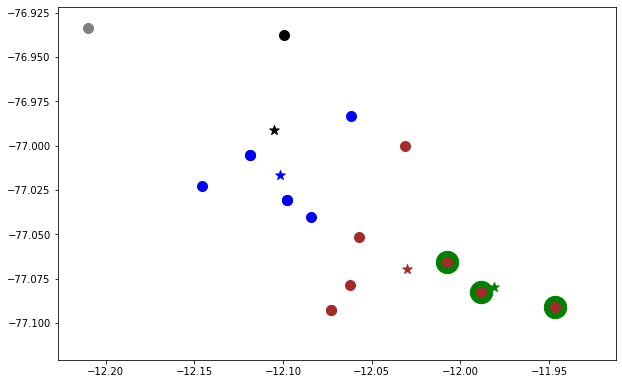

In [173]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10,10))
cut = data.head(20)

types = []
all_points = []

for ix in range(5):
    temp = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == ix]
    all_points += temp
    types += [ix] * len(temp)

temp = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == -1]
all_points += temp
types += [5] * len(temp)

for ix in range(5):
    temp = [Point(x, y) for x, y in [kmeans.cluster_centers_[ix]]]
    all_points += temp
    types += [6 + ix] * len(temp)



results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="green", markersize=500)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="black", markersize=100)
df_geo.loc[df_geo.types == 2].geometry.plot(ax=ax, color="blue", markersize=100)
df_geo.loc[df_geo.types == 3].geometry.plot(ax=ax, color="brown", markersize=100)
df_geo.loc[df_geo.types == 4].geometry.plot(ax=ax, color="gray", markersize=100)
df_geo.loc[df_geo.types == 5].geometry.plot(ax=ax, color="red", markersize=100)

df_geo.loc[df_geo.types == 6].geometry.plot(ax=ax, color="green", markersize=100, marker='*')
df_geo.loc[df_geo.types == 7].geometry.plot(ax=ax, color="black", markersize=100, marker='*')
df_geo.loc[df_geo.types == 8].geometry.plot(ax=ax, color="blue", markersize=100, marker='*')
df_geo.loc[df_geo.types == 9].geometry.plot(ax=ax, color="brown", markersize=100, marker='*')
df_geo.loc[df_geo.types == 10].geometry.plot(ax=ax, color="gray", markersize=100, marker='*')


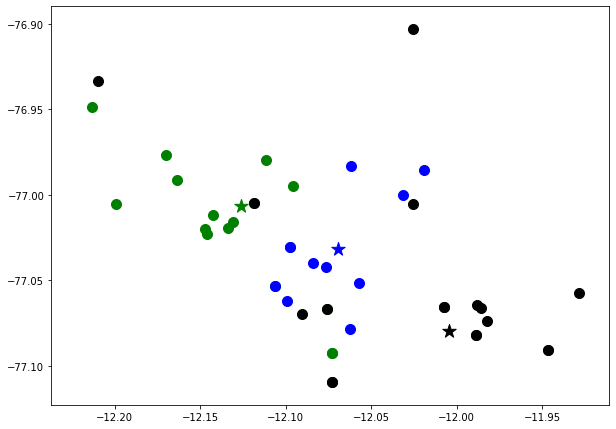

In [93]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10,10))
cut = data.head(50)
amb_points_1 = [Point(x, y) for x, y in [kmeans.cluster_centers_[1]]]
amb_points_2 = [Point(x, y) for x, y in [kmeans.cluster_centers_[2]]]
amb_points_3 = [Point(x, y) for x, y in [kmeans.cluster_centers_[3]]]
points_1 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 1]
points_2 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 2]
points_3 = [Point(x, y) for lab, x, y in zip(kmeans.labels, cut.lat.values, cut.lng.values) if lab == 3]
#red_points = [Point(x, y) for lab, x, y in zip(kmeans.labels, data.lat.values, data.lng.values) if lab == 1]

all_points = list(amb_points_1) + list(amb_points_2) + list(amb_points_3) + \
        list(points_1) + list(points_2) + list(points_3)
types = [4]*len(amb_points_1) + [5]*len(amb_points_2) + [6]*len(amb_points_3) + \
        [1]*len(points_1) + [2]*len(points_2) + [3]*len(points_3)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="green", markersize=100)
df_geo.loc[df_geo.types == 2].geometry.plot(ax=ax, color="black", markersize=100)
df_geo.loc[df_geo.types == 3].geometry.plot(ax=ax, color="blue", markersize=100)
df_geo.loc[df_geo.types == 4].geometry.plot(ax=ax, color="green", markersize=200, marker='*')
df_geo.loc[df_geo.types == 5].geometry.plot(ax=ax, color="black", markersize=200, marker='*')
df_geo.loc[df_geo.types == 6].geometry.plot(ax=ax, color="blue", markersize=200, marker='*')


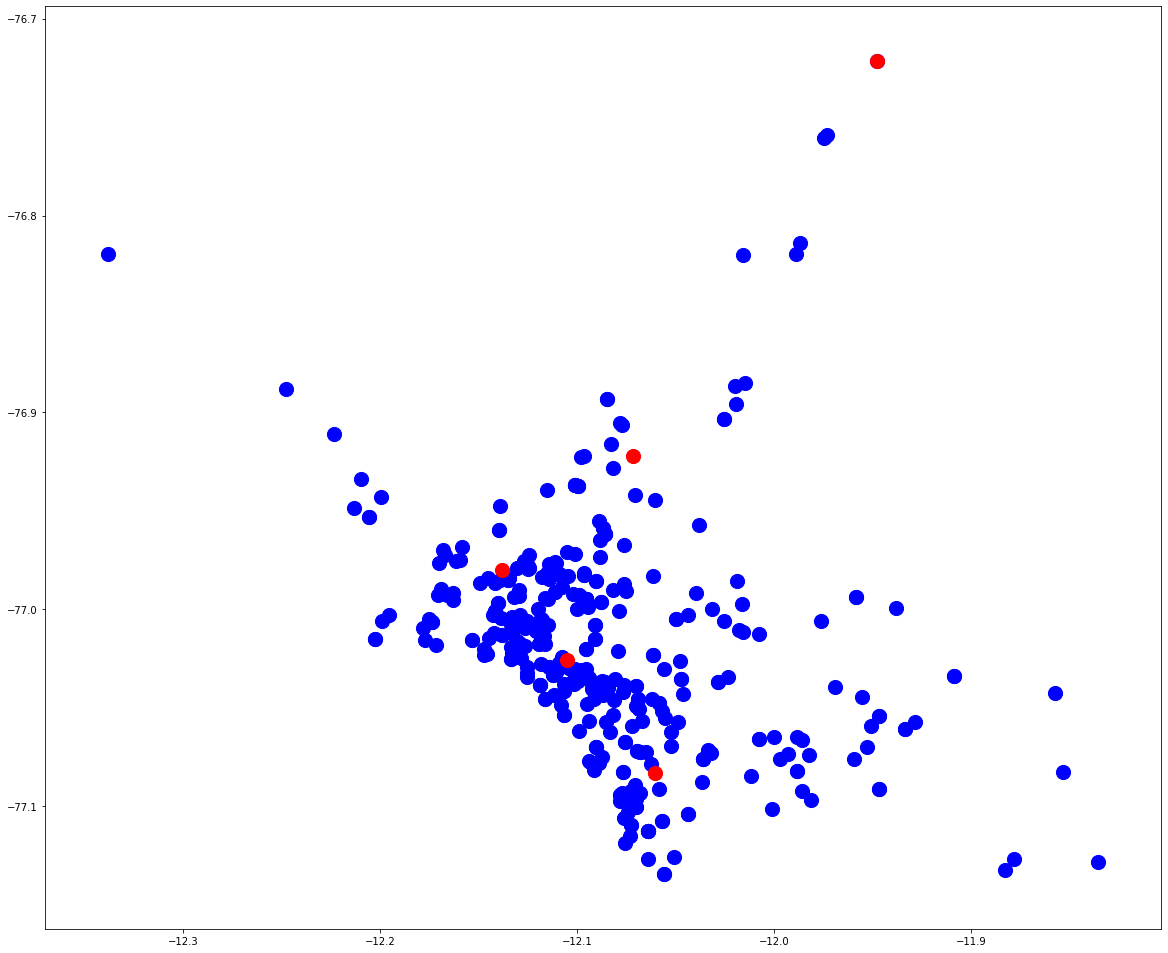

In [58]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)

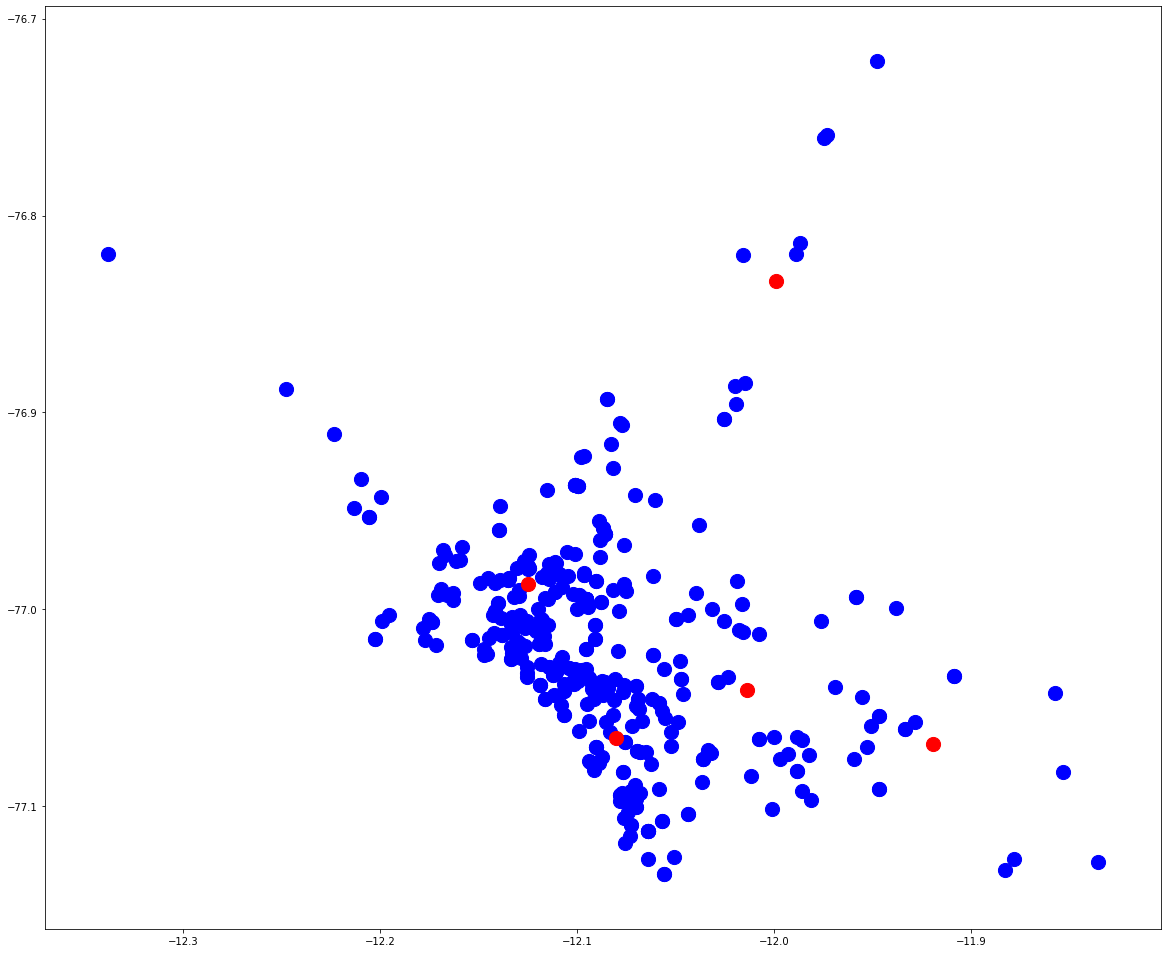

In [29]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(8, 8))

import geopandas as gpd
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(20,20))

amb_points = [Point(x, y) for x, y in kmeans.cluster_centers_]
red_points = [Point(x, y) for x, y in zip(data.lat.values, data.lng.values)]

all_points = list(red_points) + amb_points
types = [0]*len(red_points) + [1]*len(amb_points)

results = pd.DataFrame()
results['geometry'] = all_points
results['types'] = types

df_geo = gpd.GeoDataFrame(results, geometry=all_points)
df_geo.loc[df_geo.types == 0].geometry.plot(ax=ax, color="blue", markersize=200)
df_geo.loc[df_geo.types == 1].geometry.plot(ax=ax, color="red", markersize=200)